In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks

%matplotlib inline

In [3]:
df2 = pd.read_csv('/Users/Adrien/DataScientist/projet_Mushroom/data_first_model.csv')
folderpath = "/Users/Adrien/DataScientist/projet_Mushroom/images_mushroom/"
df2['filepath'] = [folderpath + str(df2['image_id'][x]) + ".jpg" for x in range(len(df2))]

#df['label'] = df['family'].replace(['Mycenaceae', 'Boletaceae', 'Strophariaceae',
#                                    'Inocybaceae', 'Polyporaceae', 'Tricholomataceae',
#                                    'Agaricaceae', 'Physalacriaceae', 'Russulaceae', 'Omphalotaceae',
#                                    'Psathyrellaceae', 'Fomitopsidaceae', 'Cortinariaceae',
#                                    'Entolomataceae', 'Marasmiaceae', 'Amanitaceae', 'Hygrophoraceae'],
#                                   [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df2.head()

,image_id,image_url,family,filepath
0,5,http://mushroomobserver.org/images/320/5,Mycenaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...
1,6,http://mushroomobserver.org/images/320/6,Mycenaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...
2,7,http://mushroomobserver.org/images/320/7,Boletaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...
3,8,http://mushroomobserver.org/images/320/8,Boletaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...
4,9,http://mushroomobserver.org/images/320/9,Boletaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...


In [4]:
liste2 = ['Inocybaceae','Omphalotaceae','Fomitopsidaceae','Physalacriaceae','Marasmiaceae']
df = df2[df2['family'].isin(liste2)]
df = df.reset_index(drop=True)
df['label'] = df['family'].replace(['Inocybaceae','Omphalotaceae','Fomitopsidaceae',
                                      'Physalacriaceae','Marasmiaceae'],
                                   [0,1,2,3,4])

display(df.head())
print(df.shape)

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1


(17137, 5)


In [5]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df['filepath'], df['label'], test_size=0.2, random_state=42)

X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=(256, 256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

100%|██████████| 3428/3428 [00:06<00:00, 513.92it/s]


In [6]:
@tf.function
def load_image(filepath, resize=(256, 256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    im = tf.image.resize(im, resize)
    return im

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(64)

In [7]:
efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers:
    layer.trainable = False

efficientNet.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [8]:
model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 5, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2

In [9]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#import os
#cwd = os.getcwd()
#filepath = cwd

checkpoint = callbacks.ModelCheckpoint(filepath='checkpoint_effnet',
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 5,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

model.fit(dataset_train, epochs=10, validation_data=(X_test, y_test), callbacks=[lr_plateau, checkpoint])


Epoch 1/10
215/215 [==============================] - 716s 3s/step - loss: 1.1293 - accuracy: 0.5348 - val_loss: 0.9712 - val_accuracy: 0.5980


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoint_effnet/assets
Epoch 2/10
215/215 [==============================] - 612s 3s/step - loss: 0.9320 - accuracy: 0.6224 - val_loss: 0.8876 - val_accuracy: 0.6348


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoint_effnet/assets
Epoch 3/10
215/215 [==============================] - 610s 3s/step - loss: 0.8394 - accuracy: 0.6678 - val_loss: 0.9067 - val_accuracy: 0.6327
Epoch 4/10
215/215 [==============================] - 606s 3s/step - loss: 0.7626 - accuracy: 0.6995 - val_loss: 0.8917 - val_accuracy: 0.6561
Epoch 5/10
215/215 [==============================] - 606s 3s/step - loss: 0.6972 - accuracy: 0.7251 - val_loss: 0.9009 - val_accuracy: 0.6663
Epoch 6/10
215/215 [==============================] - 650s 3s/step - loss: 0.6329 - accuracy: 0.7551 - val_loss: 0.8908 - val_accuracy: 0.6797
Epoch 7/10
215/215 [==============================] - 882s 4s/step - loss: 0.5961 - accuracy: 0.7753 - val_loss: 0.8841 - val_accuracy: 0.6820


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoint_effnet/assets
Epoch 8/10
215/215 [==============================] - 643s 3s/step - loss: 0.5504 - accuracy: 0.7866 - val_loss: 0.8977 - val_accuracy: 0.6899
Epoch 9/10
215/215 [==============================] - 844s 4s/step - loss: 0.4980 - accuracy: 0.8141 - val_loss: 0.9606 - val_accuracy: 0.6861
Epoch 10/10
215/215 [==============================] - 859s 4s/step - loss: 0.4602 - accuracy: 0.8221 - val_loss: 1.0108 - val_accuracy: 0.6718


In [10]:
y_prob = model.predict(X_test, batch_size=64)

y_pred = tf.argmax(y_prob, axis = 1).numpy()
y_pred

array([2, 1, 3, ..., 2, 0, 1])

l'accuracy est de : 0.6718203033838973


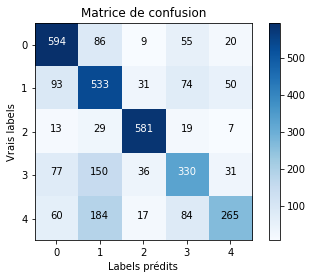

In [11]:
print("l'accuracy est de :", accuracy_score(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)

### Just for the fun !
##
#
classes = range(0,5)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()
#
##
###

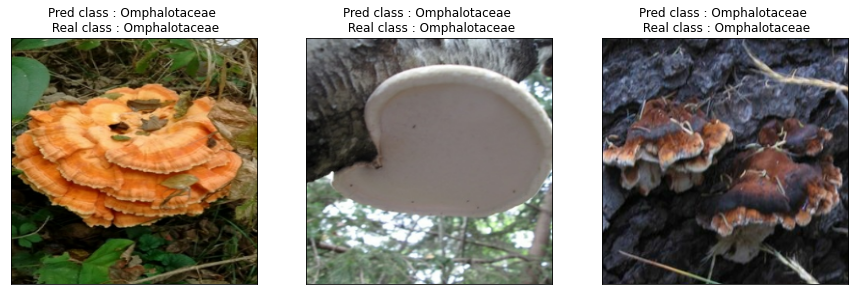

In [18]:
indices_random = tf.random.uniform([3], 0, len(X_test), dtype=tf.int32)

plt.figure(figsize=(15,7))
for i, idx in enumerate(indices_random):
    plt.subplot(1,3,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Pred class : {} \n Real class : {}'.format(df.family.unique()[y_pred[idx]], df.family.unique()[y_test.values[idx]]))

In [19]:
import h5py

In [23]:
model.save('/Users/Adrien/DataScientist/projet_Mushroom/checkpoint_effnet/model_efficientnet_part1.h5')

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
new_model = load_model('/Users/Adrien/DataScientist/projet_Mushroom/checkpoint_effnet/model_efficientnet_part1.h5')

In [25]:
new_model.fit(dataset_train, epochs=20, validation_data=(X_test, y_test), callbacks=[lr_plateau, checkpoint])

Epoch 1/20
215/215 [==============================] - 631s 3s/step - loss: 0.4196 - accuracy: 0.8413 - val_loss: 0.9798 - val_accuracy: 0.6817
Epoch 2/20
215/215 [==============================] - 646s 3s/step - loss: 0.4027 - accuracy: 0.8508 - val_loss: 0.9948 - val_accuracy: 0.6870
Epoch 3/20
215/215 [==============================] - 655s 3s/step - loss: 0.3688 - accuracy: 0.8641 - val_loss: 1.0515 - val_accuracy: 0.6873
Epoch 4/20
215/215 [==============================] - 639s 3s/step - loss: 0.3578 - accuracy: 0.8662 - val_loss: 1.0076 - val_accuracy: 0.6940
Epoch 5/20
215/215 [==============================] - 637s 3s/step - loss: 0.3247 - accuracy: 0.8789 - val_loss: 1.1253 - val_accuracy: 0.6762
Epoch 6/20
215/215 [==============================] - 637s 3s/step - loss: 0.3175 - accuracy: 0.8826 - val_loss: 1.1058 - val_accuracy: 0.6954

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
215/215 [==============================] - 630s 3

### Sauvegarder le modèle :

- permet de continuer l'entrainement...
- reloader pour faire des prédictions plus tard...

In [27]:
### Set the path and name you want !
##
#
save_name = "/Users/Adrien/DataScientist/projet_Mushroom/checkpoint_effnet/model_efficientNet_20210617.h5"
#
##
###


model.save(save_name)

### Predict X_test and get the prediction

(using argmax car softmax renvoie des probabilités)

In [28]:
y_prob = new_model.predict(X_test, batch_size=64)

y_pred = tf.argmax(y_prob, axis = 1).numpy()
y_pred

array([2, 1, 3, ..., 2, 1, 1])

### Evaluer l'accuracy, le f1 du modèle, présenter une matrice de confusion :

l'accuracy est de : 0.7135355892648775


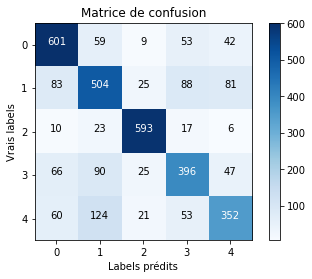

In [30]:
print("l'accuracy est de :", accuracy_score(y_test, y_pred))
#print("\nle f1 score est de :", f1_score(y_test, y_pred), "\n\n")

cnf_matrix = confusion_matrix(y_test, y_pred)



### Just for the fun !
##
#
#
#
#
classes = range(0,(df['family'].nunique()))

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()
#
#
#
#
##
###

### Afficher 3 images au hasard assorties de leur label réel / label prédit

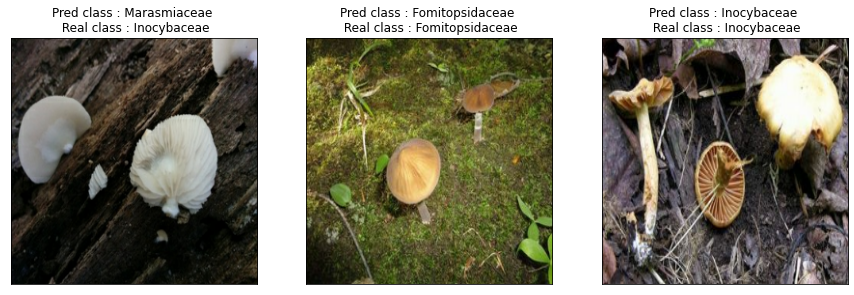

In [33]:
indices_random = tf.random.uniform([3], 0, len(X_test), dtype=tf.int32)

plt.figure(figsize=(15,7))
for i, idx in enumerate(indices_random):
    plt.subplot(1,3,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Pred class : {} \n Real class : {}'.format(df.family.unique()[y_pred[idx]], df.family.unique()[y_test.values[idx]]))